## 「ベイズ推論による機械学習入門」
##   P.145 ガウス混合モデルに対するギブスサンプリング

In [1]:
using Distributions
using Plots
using Random

Random.seed!(1234) # 再現性のためシードを設定

## 真のモデル

In [2]:
N = 300
D = 2
K = 3

μ₁_true = [5.0; 35.0]
μ₂_true = [-20.0; 10.0]
μ₃_true = [30.0; -20.0]

Σ₁_true = [
    250.0 65.0
    65.0 270.0
]

Σ₂_true = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃_true = [
    210.0 -15.0
    -15.0 250.0
]

π_true = [0.45, 0.25, 0.3]

multi_gaussian = MvNormal[
    MvNormal(μ₁_true, Σ₁_true), 
    MvNormal(μ₂_true, Σ₂_true), 
    MvNormal(μ₃_true, Σ₃_true)
]

true_model = MixtureModel(multi_gaussian, π_true)

MixtureModel{MvNormal}(K = 3)
components[1] (prior = 0.4500): FullNormal(
dim: 2
μ: [5.0, 35.0]
Σ: [250.0 65.0; 65.0 270.0]
)

components[2] (prior = 0.2500): FullNormal(
dim: 2
μ: [-20.0, 10.0]
Σ: [125.0 -45.0; -45.0 175.0]
)

components[3] (prior = 0.3000): FullNormal(
dim: 2
μ: [30.0, -20.0]
Σ: [210.0 -15.0; -15.0 250.0]
)



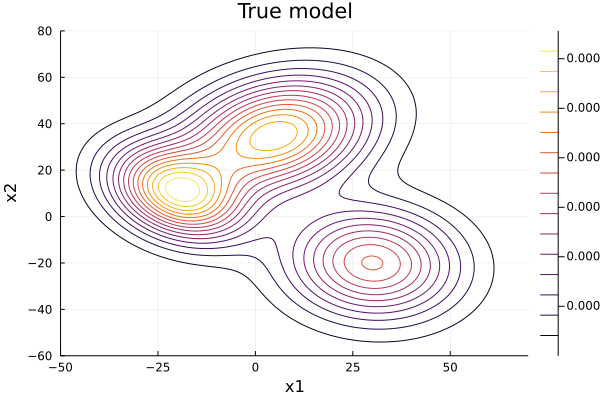

In [3]:
contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), title="True model", xlabel="x1", ylabel="x2")